# Dropout and Data Augmentation
In this exercise we will implement two ways to reduce overfitting.

Like the previous assignment, we will train ConvNets to recognize the categories in CIFAR-10. However unlike the previous assignment where we used 49,000 images for training, in this exercise we will use just 500 images for training.

If we try to train a high-capacity model like a ConvNet on this small amount of data, we expect to overfit, and end up with a solution that does not generalize. We will see that we can drastically reduce overfitting by using dropout and data augmentation.

In [1]:
# A bit of setup

import numpy as np
import matplotlib.pyplot as plt
from time import time
from skynet.neural_network.layers import *
from skynet.neural_network.fast_layers import *
from skynet.utils.data_utils import load_CIFAR10

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# Load data
For this exercise our training set will contain 500 images and our validation and test sets will contain 1000 images as usual.

In [2]:
from skynet.utils.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=500, num_validation=1000, num_test=1000, normalize=True):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '../skynet/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    if normalize:
        mean_image = np.mean(X_train, axis=0)
        X_train -= mean_image
        X_val -= mean_image
        X_test -= mean_image
    
    # Transpose so that channels come first
    X_train = X_train.transpose(0, 3, 1, 2).copy()
    X_val = X_val.transpose(0, 3, 1, 2).copy()
    X_test = X_test.transpose(0, 3, 1, 2).copy()

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(num_training=500)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (500, 3, 32, 32)
Train labels shape:  (500,)
Validation data shape:  (1000, 3, 32, 32)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3, 32, 32)
Test labels shape:  (1000,)


# Overfit
Now that we've loaded our data, we will attempt to train a three layer convnet on this data. The three layer convnet has the architecture

`conv - relu - pool - affine - relu - affine - softmax`

We will use 32 5x5 filters, and our hidden affine layer will have 128 neurons.

This is a very expressive model given that we have only 500 training samples, so we should expect to massively overfit this dataset, and achieve a training accuracy of nearly 0.9 with a much lower validation accuracy.

In [3]:
from skynet.neural_network.classifiers.convnet import *
from skynet.solvers.classifier_trainer import ClassifierTrainer

model = init_three_layer_convnet(filter_size=5, num_filters=(32, 128))
trainer = ClassifierTrainer()
best_model, loss_history, train_acc_history, val_acc_history = trainer.train(
          X_train, y_train, X_val, y_val, model, three_layer_convnet, dropout=None,
          reg=0.05, learning_rate=0.00005, batch_size=50, num_epochs=15,
          learning_rate_decay=1.0, update='rmsprop', verbose=True)

starting iteration  0
Finished epoch 0 / 15: cost 4.972814, train: 0.180000, val 0.135000, lr 5.000000e-05
Finished epoch 1 / 15: cost 4.419795, train: 0.354000, val 0.249000, lr 5.000000e-05
starting iteration  10
Finished epoch 2 / 15: cost 3.797447, train: 0.418000, val 0.292000, lr 5.000000e-05
starting iteration  20
Finished epoch 3 / 15: cost 3.691759, train: 0.570000, val 0.324000, lr 5.000000e-05
starting iteration  30
Finished epoch 4 / 15: cost 3.428825, train: 0.536000, val 0.321000, lr 5.000000e-05
starting iteration  40
Finished epoch 5 / 15: cost 3.268378, train: 0.620000, val 0.335000, lr 5.000000e-05
starting iteration  50
Finished epoch 6 / 15: cost 3.131763, train: 0.686000, val 0.356000, lr 5.000000e-05
starting iteration  60
Finished epoch 7 / 15: cost 2.967952, train: 0.744000, val 0.361000, lr 5.000000e-05
starting iteration  70
Finished epoch 8 / 15: cost 2.925799, train: 0.746000, val 0.367000, lr 5.000000e-05
starting iteration  80
Finished epoch 9 / 15: cost 2

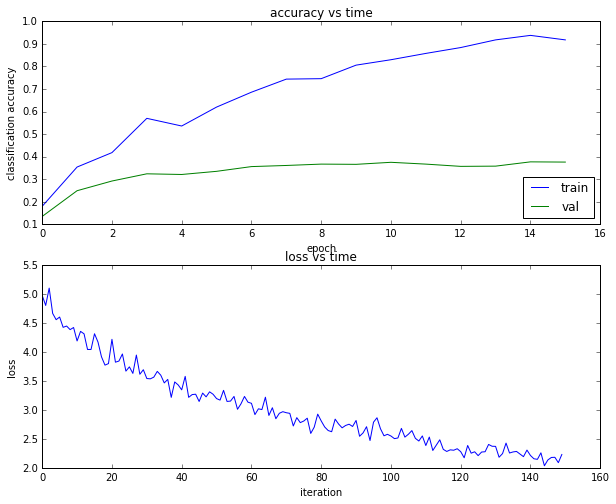

In [4]:
# Visualize the loss and accuracy for our network trained on a small dataset

plt.subplot(2, 1, 1)
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.title('accuracy vs time')
plt.legend(['train', 'val'], loc=4)
plt.xlabel('epoch')
plt.ylabel('classification accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_history)
plt.title('loss vs time')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

# Dropout
The first way we will reduce overfitting is to use dropout.

Open the file `cs231n/layers.py` and implement the `dropout_forward` and `dropout_backward` functions. We can check the forward pass by looking at the statistics of the outputs in train and test modes, and we can check the backward pass using numerical gradient checking.

In [5]:
# Check the dropout forward pass

x = np.random.randn(100, 100)
dropout_param_train = {'p': 0.25, 'mode': 'train'}
dropout_param_test = {'p': 0.25, 'mode': 'test'}

out_train, _ = dropout_forward(x, dropout_param_train)
out_test, _ = dropout_forward(x, dropout_param_test)

# Test dropout training mode; about 25% of the elements should be nonzero
print(np.mean(out_train != 0))

# Test dropout test mode; all of the elements should be nonzero
print(np.mean(out_test != 0))

0.7449
1.0


In [6]:
from skynet.utils.gradient_check import eval_numerical_gradient_array

# Check the dropout backward pass

x = np.random.randn(5, 4)
dout = np.random.randn(*x.shape)
dropout_param = {'p': 0.8, 'mode': 'train', 'seed': 123}

dx_num = eval_numerical_gradient_array(lambda x: dropout_forward(x, dropout_param)[0], x, dout)

_, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)

# The error should be around 1e-12
print('Testing dropout_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing dropout_backward function:
dx error:  5.51291055509e-14


# Data Augmentation
The next way we will reduce overfitting is to implement data augmentation. Since we have very little training data, we will use what little training data we have to generate artificial data, and use this artificial data to train our network.

CIFAR-10 images are 32x32, and up until this point we have used the entire image as input to our convnets. Now we will do something different: our convnet will expect a smaller input (say 28x28). Instead of feeding our training images directly to the convnet, at training time we will randomly crop each training image to 28x28, randomly flip half of the training images horizontally, and randomly adjust the contrast and tint of each training image.

Open the file `cs231n/data_augmentation.py` and implement the `random_flips`, `random_crops`, `random_contrast`, and `random_tint` functions. In the same file we have implemented the `fixed_crops` function to get you started. When you are done you can run the cell below to visualize the effects of each type of data augmentation.

X data type: float64


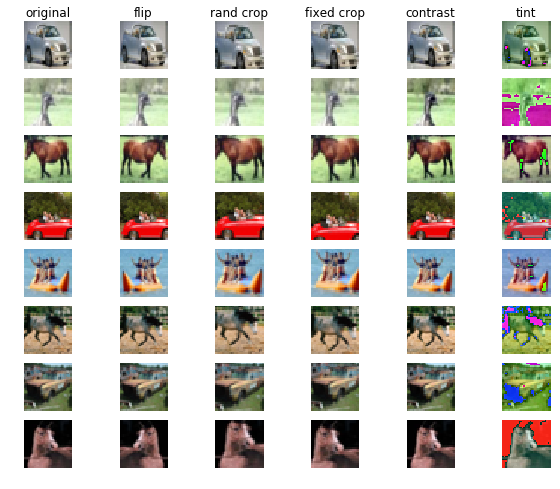

In [7]:
from skynet.preprocessing.data_augmentation import *

X = get_CIFAR10_data(num_training=100, normalize=False)[0]
num_imgs = 8
print('X data type:', X.dtype)
X = X[np.random.randint(100, size=num_imgs)]

X_flip = random_flips(X)
X_rand_crop = random_crops(X, (28, 28))
X_fixed_crop = random_crops(X, (28, 28))

# To give more dramatic visualizations we use large scales for random contrast
# and tint adjustment.
X_contrast = random_contrast(X, scale=(0.5, 1.0))
X_tint = random_tint(X, scale=(-50, 50))


next_plt = 1
for i in range(num_imgs):
    titles = ['original', 'flip', 'rand crop', 'fixed crop', 'contrast', 'tint']
    for j, XX in enumerate([X, X_flip, X_rand_crop, X_fixed_crop, X_contrast, X_tint]):
        plt.subplot(num_imgs, 6, next_plt)
        img = XX[i].transpose(1, 2, 0)
        if j == 4:
            # For visualization purposes we rescale the pixel values of the
            # tinted images
            low, high = np.min(img), np.max(img)
            img = 255 * (img - low) / (high - low)
        plt.imshow(img.astype('uint8'))
        if i == 0:
            plt.title(titles[j])
        plt.gca().axis('off')
        next_plt += 1
plt.show()

# Train again
We will now train a new network with the same training data and the same architecture, but using data augmentation and dropout.

If everything works, you should see a higher validation accuracy than above and a smaller gap between the training accuracy and the validation accuracy.

Networks with dropout usually take a bit longer to train, so we will use more training epochs this time.

In [8]:
input_shape = (3, 28, 28)

def augment_fn(X):
    out = random_flips(random_crops(X, input_shape[1:]))
    out = random_tint(random_contrast(out))
    return out

def predict_fn(X):
    return fixed_crops(X, input_shape[1:], 'center')
    
model = init_three_layer_convnet(filter_size=5, input_shape=input_shape, num_filters=(32, 128))
trainer = ClassifierTrainer()

best_model, loss_history, train_acc_history, val_acc_history = trainer.train(
          X_train, y_train, X_val, y_val, model, three_layer_convnet,
          reg=0.05, learning_rate=0.00005, learning_rate_decay=1.0,
          batch_size=50, num_epochs=30, update='rmsprop', verbose=True, dropout=0.6,
          augment_fn=augment_fn, predict_fn=predict_fn)

starting iteration  0
Finished epoch 0 / 30: cost 4.472581, train: 0.132000, val 0.117000, lr 5.000000e-05
Finished epoch 1 / 30: cost 3.886180, train: 0.244000, val 0.195000, lr 5.000000e-05
starting iteration  10
Finished epoch 2 / 30: cost 3.920776, train: 0.312000, val 0.274000, lr 5.000000e-05
starting iteration  20
Finished epoch 3 / 30: cost 3.543947, train: 0.340000, val 0.271000, lr 5.000000e-05
starting iteration  30
Finished epoch 4 / 30: cost 3.477914, train: 0.358000, val 0.286000, lr 5.000000e-05
starting iteration  40
Finished epoch 5 / 30: cost 3.423414, train: 0.382000, val 0.319000, lr 5.000000e-05
starting iteration  50
Finished epoch 6 / 30: cost 3.327101, train: 0.400000, val 0.273000, lr 5.000000e-05
starting iteration  60
Finished epoch 7 / 30: cost 3.324110, train: 0.404000, val 0.288000, lr 5.000000e-05
starting iteration  70
Finished epoch 8 / 30: cost 3.327097, train: 0.444000, val 0.322000, lr 5.000000e-05
starting iteration  80
Finished epoch 9 / 30: cost 3

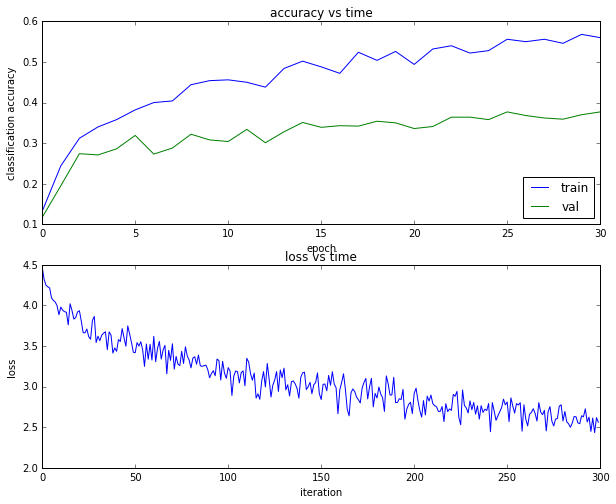

In [9]:
# Visualize the loss and accuracy for our network trained with dropout and data augmentation.
# You should see less overfitting, and you may also see slightly better performance on the
# validation set.

plt.subplot(2, 1, 1)
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.title('accuracy vs time')
plt.legend(['train', 'val'], loc=4)
plt.xlabel('epoch')
plt.ylabel('classification accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_history)
plt.title('loss vs time')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()